# Step #1 Generate Synthetic Time Series Data

Tensorflow Version: 2.3.0
Num GPUs: 0


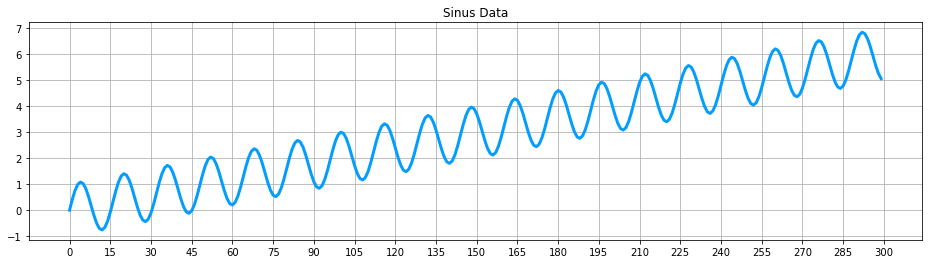

In [1]:
# A tutorial for this file is available at www.relataly.com

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Creating the synthetic sinus curve dataset
steps = 300
gradient = 0.02
list_a = []
for i in range(0, steps, 1):
    y = round(gradient * i + math.sin(math.pi * 0.125 * i), 5)
    list_a.append(y)
df = pd.DataFrame({"valid": list_a}, columns=["valid"])

# Visualizing the data
fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title("Sinus Data")
plt.plot(df[["valid"]], color="#039dfc", linewidth=3.0)
plt.grid()
plt.show()

# Step #2 Preprocessing

In [2]:
data = df.copy()

# Get the number of rows in the data
nrows = df.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(df)
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

(300, 1)


In [3]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 110

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

(130, 110, 1) (130,)
(60, 110, 1) (60,)
0.599655121905751
0.599655121905751


# Step #3 Train the Model

In [4]:
# Configure the neural network model
epochs = 12; batch_size = 1;

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
model = Sequential()
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/12
130/130 [==============================] - 4s 29ms/step - loss: 0.0583
Epoch 2/12
130/130 [==============================] - 4s 29ms/step - loss: 0.0014
Epoch 3/12
130/130 [==============================] - 4s 29ms/step - loss: 1.6681e-04
Epoch 4/12
130/130 [==============================] - 4s 29ms/step - loss: 2.6663e-04
Epoch 5/12
130/130 [==============================] - 4s 30ms/step - loss: 1.3162e-04
Epoch 6/12
130/130 [==============================] - 4s 29ms/step - loss: 1.9042e-04
Epoch 7/12
130/130 [==============================] - 4s 28ms/step - loss: 9.5267e-04
Epoch 8/12
130/130 [==============================] - 4s 30ms/step - loss: 0.0011
Epoch 9/12
130/130 [==============================] - 4s 28ms/step - loss: 2.7323e-04
Epoch 10/12
130/130 [==============================] - 4s 29ms/step - loss: 3.2296e-04
Epoch 11/12
130/130 [==============================] - 4s 33ms/step - loss: 3.6298e-05
Epoch 12/12
130/130 [==============================] - 4s 30ms/s

# Step #4 Predicting a Single-step Ahead

In [5]:
# Reshape the data, so that we get an array with multiple test datasets
x_test_np = np.array(x_test)
x_test_reshape = np.reshape(x_test_np, (x_test_np.shape[0], x_test_np.shape[1], 1))

# Get the predicted values
y_pred = model.predict(x_test_reshape)
y_pred_unscaled = scaler.inverse_transform(y_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_unscaled)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 0.05
Mean Absolute Percentage Error (MAPE): 1.05 %
Median Absolute Percentage Error (MDAPE): 0.92 %


# Step #5 Visualizing Predictions and Loss

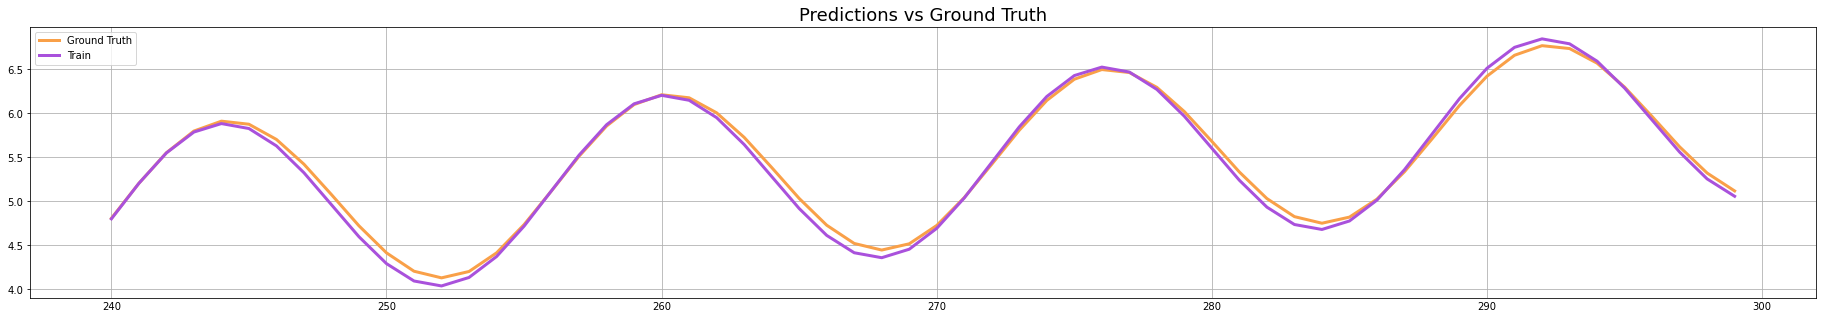

In [6]:
# Visualize the data
#train = df[:train_data_len]
df_valid_pred = df[train_data_len:]
df_valid_pred.insert(1, "Predictions", y_pred_unscaled, True)
fig, ax1 = plt.subplots(figsize=(32, 5), sharex=True)

ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("Predictions vs Ground Truth", fontsize=18)
plt.plot(df_valid_pred["Predictions"], color="#F9A048", linewidth=3.0)
plt.plot(df_valid_pred["valid"], color="#A951DC", linewidth=3.0)
plt.legend(["Ground Truth", "Train"], loc="upper left")
plt.grid()
plt.show()

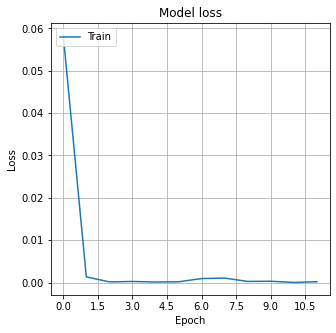

In [7]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #6 Multi-step Time Series Predictions

In [8]:
# Settings and Model Labels
rolling_forecast_range = 30
titletext = "Forecast Chart Model A"
ms = [
    ["epochs", epochs],
    ["batch_size", batch_size],
    ["lstm_neuron_number", n_neurons],
    ["rolling_forecast_range", rolling_forecast_range],
    ["layers", "LSTM, DENSE(1)"],
]
settings_text = ""
lms = len(ms)
for i in range(0, lms):
    settings_text += ms[i][0] + ": " + str(ms[i][1])
    
    if i < lms - 1:
        settings_text = settings_text + ",  "

# Making a Multi-Step Prediction
new_df = df.filter(["valid"])
for i in range(0, rolling_forecast_range):
    last_values = new_df[-n_neurons:].values
    last_values_scaled = scaler.transform(last_values)
    X_input = []
    X_input.append(last_values_scaled)
    X_input = np.array(X_input)
    X_test = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    pred_value = model.predict(X_input)
    pred_value_unscaled = scaler.inverse_transform(pred_value)
    new_df = new_df.append(pd.DataFrame({"valid": pred_value_unscaled[0, 0]}, index=new_df.iloc[[-1]].index.values + 1))
    new_df_length = new_df.size
forecast = new_df[new_df_length - rolling_forecast_range : new_df_length].rename(
    columns={"valid": "Forecast"}
)

# Step #6 Visualize the Results

In [9]:
#Visualize the results
validxs = df_valid_pred.copy()
dflen = new_df.size - 1
dfs = pd.concat([validxs, forecast], sort=False)
dfs.at[dflen, "Forecast"] = dfs.at[dflen, "Predictions"]
dfs

,valid,Predictions,Forecast
240,4.80000,4.806314,NaN
241,5.20268,5.202820,NaN
242,5.54711,5.549180,NaN
243,5.78388,5.795299,NaN
244,5.88000,5.907301,NaN
...,...,...,...
325,NaN,NaN,7.137596
326,NaN,NaN,7.049226
327,NaN,NaN,6.853666
328,NaN,NaN,6.580579


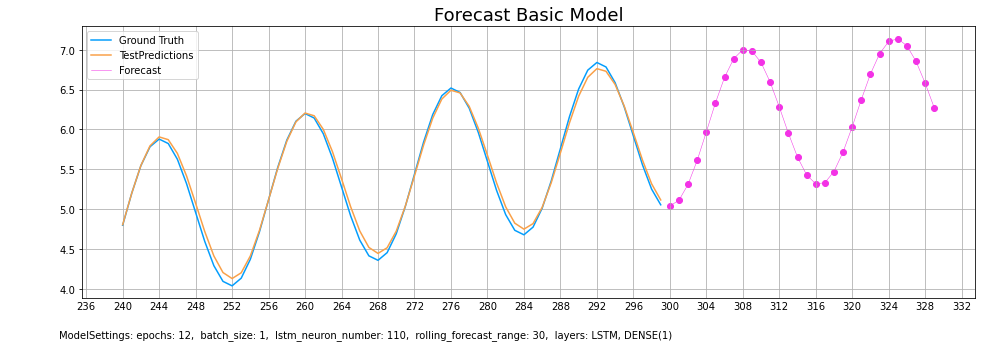

In [10]:

# Zoom in to a closer timeframe
dfs = dfs[dfs.index > 200]

# Visualize the data
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
ax.tick_params(axis="x", rotation=0, labelsize=10, length=0)
ax.xaxis.set_major_locator(plt.MaxNLocator(rolling_forecast_range))
plt.title('Forecast Basic Model', fontsize=18)
plt.plot(dfs["valid"], color="#039dfc", linewidth=1.5)
plt.plot(dfs["Predictions"], color="#F9A048", linewidth=1.5)
plt.scatter(forecast.index, forecast, color="#F332E6", linewidth=1.0)
plt.plot(forecast, color="#F332E6", linewidth=0.5)
plt.legend(["Ground Truth", "TestPredictions", "Forecast"], loc="upper left")
ax.annotate('ModelSettings: ' + settings_text, xy=(0.06, .015),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)
plt.grid()
plt.show()